In [ ]:
import os
import json

result_dir = "../exp_results"
num_cores = [1]
num_tasks = [3,6,9,12]
utilizations = [0.4, 0.6, 0.8]
num_tasksets = 30
summary_path = result_dir + "/summary.csv"

# if summary file exists, remove it
if os.path.exists(summary_path):
    os.remove(summary_path)
    
header = "numCores,numTasks,utilization,tasksetIndex,realLinux_schedulability"
with open(summary_path, "a") as f:
    f.write(header + "\n")

for num_core in num_cores:
    for num_task in num_tasks:
        for utilization in utilizations:
            for i in range(num_tasksets):
                result_file = result_dir + "/details/" + str(num_core) + "cores/" + str(num_task) + "tasks/" + str(utilization) + "utilization/result_" + str(i) + ".json"
                with open(result_file, 'r') as file:
                    tasks_result = json.load(file)
                assert len(tasks_result) == num_task
                
                realLinux_schedulability = True
                for task_result in tasks_result:
                    if task_result["wcrt_ns"] > task_result["deadline_ns"]:
                        realLinux_schedulability = False
                        break
                with open(summary_path, "a") as f:
                    f.write(str(num_core) + "," + str(num_task) + "," + str(utilization) + "," + str(i) + "," + str(realLinux_schedulability) + "\n")
                


In [ ]:
import json
import pandas as pd

# analyze the exp with non_rt_task
result_dir = "../exp_results_non_RT"
schedulers = ["CFS", "FIFO", "RR", "RM"]

# set task_info in dataset
result_path = result_dir + "/" + schedulers[-1] + "_result.json"
results_df = pd.read_json(result_path)
results_df = results_df[["task_name", "deadline_ns", "wcet_ns", "priority"]]

for scheduler in schedulers:
    result_path = result_dir + "/" + scheduler + "_result.json"
    result_df = pd.read_json(result_path)
    result_df = result_df[["task_name", "wcrt_ns"]]
    result_df.columns = ["task_name", scheduler + "_wcrt_ns"]
    results_df = pd.merge(results_df, result_df, on="task_name")

# convert to ms
results_df["deadline_ms"] = results_df["deadline_ns"] / 1000000
results_df["wcet_ms"] = results_df["wcet_ns"] / 1000000
results_df["CFS_wcrt_ms"] = results_df["CFS_wcrt_ns"] / 1000000
results_df["FIFO_wcrt_ms"] = results_df["FIFO_wcrt_ns"] / 1000000
results_df["RR_wcrt_ms"] = results_df["RR_wcrt_ns"] / 1000000
results_df["RM_wcrt_ms"] = results_df["RM_wcrt_ns"] / 1000000

# round to 2 decimal places
results_df = results_df.round(1)

# drop ns columns
results_df = results_df.drop(["deadline_ns", "wcet_ns", "CFS_wcrt_ns", "FIFO_wcrt_ns", "RR_wcrt_ns", "RM_wcrt_ns"], axis=1)
results_df

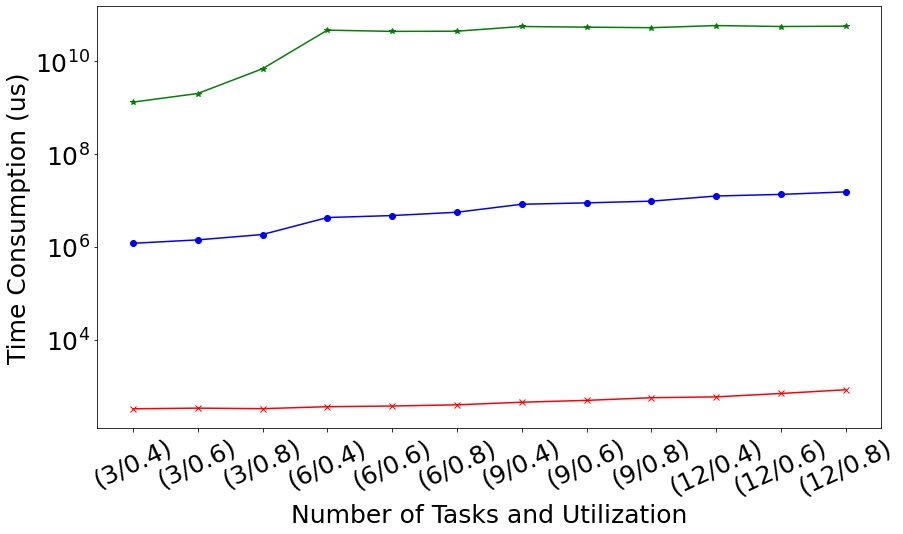

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# load data from 
file_path = "/home/ykw6644/workspace/SchedulabilityAnalysis/paper_experiment/cfs-wcrt-simulator/exp_results/time_analysis2.xlsx"
time_df = pd.read_excel(file_path)

time_df = time_df[2:]
time_df.columns = time_df.iloc[0]
time_df = time_df[1:]

time_df = time_df.drop(["schedule_count", "simulated time"], axis=1)

grouped = time_df.groupby(["numTasks", "utilization"]).mean().reset_index()

# grouped["simulator_timeConsumption(us)"] = np.log10(grouped["simulator_timeConsumption(us)"].astype(int))
# grouped["proposed_timeConsumption(us)"] = np.log10(grouped["proposed_timeConsumption(us)"].astype(int))
# grouped["realLinux_timeConsumption(us)"] = np.log10(grouped["realLinux_timeConsumption(us)"].astype(int))
# grouped = grouped.round(2)
grouped["simulator_timeConsumption(us)"] = grouped["simulator_timeConsumption(us)"].astype(int)
grouped["proposed_timeConsumption(us)"] = grouped["proposed_timeConsumption(us)"].astype(int)
grouped["realLinux_timeConsumption(us)"] = grouped["realLinux_timeConsumption(us)"].astype(int)


labels = []
simulated = []
proposed = []
realLinux = []

# set f"({data.numTasks}, {data.utilization}) from grouped into labels
for index, data in grouped.iterrows():
    labels.append(f"({data.numTasks}/{data.utilization})")
    simulated.append(data["simulator_timeConsumption(us)"])
    proposed.append(data["proposed_timeConsumption(us)"])
    realLinux.append(data["realLinux_timeConsumption(us)"])


fontsize = 25
tick_rotation = 25
# Create the box plot
plt.figure(figsize=(12, 7))

plt.yscale("log")
# draw plot for simulated and labels
plt.plot(labels, simulated, marker='o', linestyle='-', color='b', label='Simulated')
plt.plot(labels, proposed, marker='x', linestyle='-', color='r', label='Proposed')
plt.plot(labels, realLinux, marker='*', linestyle='-', color='g', label='RealLinux')
plt.xticks(rotation=tick_rotation)
plt.xlabel('Number of Tasks and Utilization', fontsize=fontsize)
plt.ylabel('Time Consumption (us)', fontsize=fontsize)
# plt.title(title, fontsize=fontsize)
plt.tight_layout()

plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)

# Display the plot
plt.show()

    
